# Overview

This tutorial provides the following information:

- how to use `networkx` to generate the graph from a tabulated dataset.
- how to configure the pytorch geometric (`pyg`) data set for training.
- how to train and evaluate the model based on `pyg`.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx

import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GATv2Conv

from tqdm.auto import tqdm

np.random.seed(42)

## Preparation

The packages needed for this tutorial is provided as a conda environment file in `environment.yml`.
Although it is possible to run this tutorial with GPU support, it is recommended to run this notebook on a system that has GPU support.
Cloud services such as [Google Colab](https://colab.research.google.com/) can also be used for this purpose.

## Construct network with `networkx`

Most real world data are usually stored in a customized format that can often be parsed into data frame.
Once the network data is in a data frame, we can use `networkx` to construct a graph.

For this tutorial, a synthetic traffic network is generated using `netgenerate` from [SUMO](https://sumo.dlr.de/docs/NETGEN.html).

```bash
netgenerate --rand --output-file=randnetwork.net.xml
```

The generated network is shown below:

![network](./images/randnetwork.png)

In [2]:
# parse network into a dataframe
df_edge = pd.read_xml("data/randnetwork.net.xml", xpath=".//edge")
# drop internal edges (i.e. edges with NaN from/to)
df_edge = df_edge[df_edge["from"].notna() & df_edge["to"].notna()]

df_edge

,id,function,lane,from,to,priority
1108,-1005,None,NaN,1004.0,611.0,-1.0
1109,-1011,None,NaN,1010.0,611.0,-1.0
1110,-1027,None,NaN,1026.0,697.0,-1.0
1111,-1029,None,NaN,1004.0,727.0,-1.0
1112,-1033,None,NaN,881.0,733.0,-1.0
...,...,...,...,...,...,...
1383,870,None,NaN,727.0,678.0,-1.0
1384,876,None,NaN,638.0,875.0,-1.0
1385,880,None,NaN,638.0,879.0,-1.0
1386,882,None,NaN,638.0,881.0,-1.0


In [3]:
# building a directed graph
digraph = nx.from_pandas_edgelist(
        df=df_edge,
        source="from",
        target="to",
        edge_attr=["id"],
        create_using=nx.DiGraph(),
)

# we are interested in the number of cars on the road (i.e. edges in the network),
# therefore we need to convert it to the line graph so that the GNN problem can
# be formulated as a node prediction problem (more models are available) instead
# of an edge attribute prediction problem.
dilgraph = nx.line_graph(digraph)

# bookkeeping
df_line = nx.to_pandas_edgelist(dilgraph)
df_edge["line_graph_id"] = df_edge[["from", "to"]].apply(
        lambda x: (x["from"], x["to"]), axis=1
)
df_line["from"] = df_line["source"].apply(
        lambda x: df_edge.loc[df_edge["line_graph_id"] == x]["id"].values[0]
)
df_line["to"] = df_line["target"].apply(
        lambda x: df_edge.loc[df_edge["line_graph_id"] == x]["id"].values[0]
)

df_line

,source,target,from,to
0,"(1004.0, 611.0)","(611.0, 576.0)",-1005,-612
1,"(1004.0, 611.0)","(611.0, 1004.0)",-1005,1005
2,"(1004.0, 611.0)","(611.0, 1010.0)",-1005,1011
3,"(611.0, 576.0)","(576.0, 382.0)",-612,-577
4,"(611.0, 576.0)","(576.0, 607.0)",-612,608
...,...,...,...,...
913,"(845.0, 641.0)","(641.0, 591.0)",-846,-642
914,"(845.0, 641.0)","(641.0, 839.0)",-846,840
915,"(845.0, 641.0)","(641.0, 845.0)",-846,846
916,"(847.0, 649.0)","(649.0, 591.0)",-848,-650


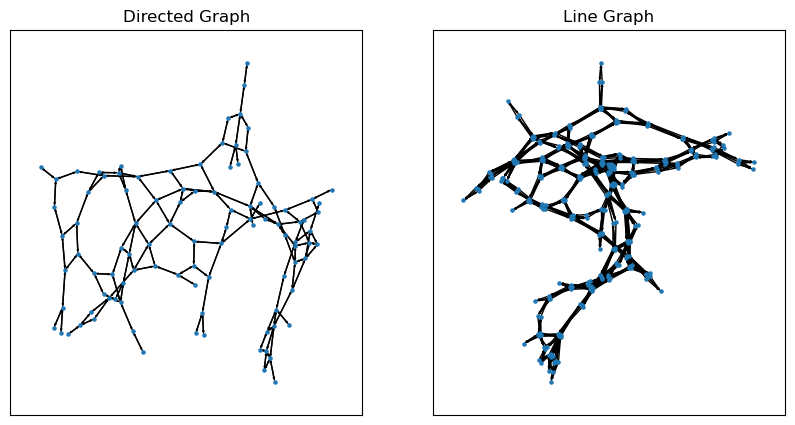

In [4]:
# we can view the network with networkx and matplotlib
_, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].set_title("Directed Graph")
nx.draw_networkx(digraph, ax=ax[0], with_labels=False, node_size=5, arrowsize=2)
ax[1].set_title("Line Graph")
nx.draw_networkx(dilgraph, ax=ax[1], with_labels=False, node_size=5, arrowsize=2)


## Generate fake traffic data

For this tutorial, we will generate fake traffic data with the following assumptions:

- total number of cars does not change between time steps.
- the traffic flow between connected roads follows fixed probability distribution.

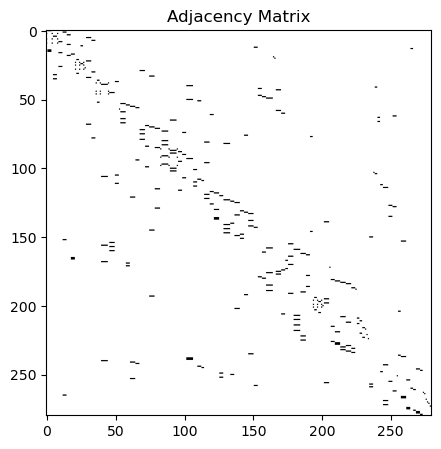

In [5]:
adaj = nx.to_numpy_array(dilgraph)

# we can also view the adjacency matrix
plt.figure(figsize=(5, 5))
plt.imshow(adaj, cmap="Greys")
plt.title("Adjacency Matrix")
plt.show()

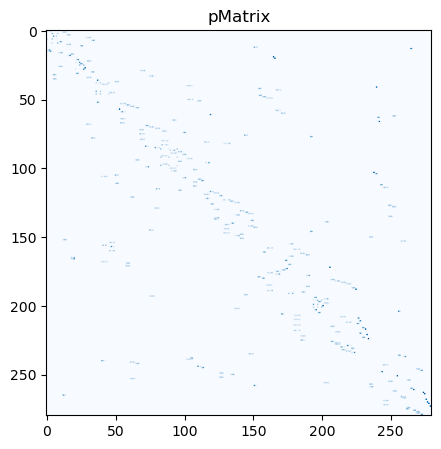

In [6]:
# create the transition probability matrix, pmatrix
pmatrix = np.random.random(adaj.shape)
pmatrix = pmatrix * adaj
pmatrix = pmatrix / pmatrix.sum(axis=1, keepdims=True)

# we can also view the transition probability matrix
plt.figure(figsize=(5, 5))
plt.imshow(pmatrix, cmap="Blues")
plt.title("pMatrix")
plt.show()

`pyg` has its own data format, which is a `torch_geometric.data.Data` object.
In order to use `pyg` for GNN training, we need to convert the traffic data to `pyg`'s data.

In [7]:
# getting the edge index list
unique_edge_ids = list(np.unique(df_line[["from", "to"]].values))

id_from = np.array(df_line["from"].apply(lambda x: unique_edge_ids.index(x)).values)
id_to = np.array(df_line["to"].apply(lambda x: unique_edge_ids.index(x)).values)

edge_index = torch.tensor([id_from, id_to], dtype=torch.long)

edge_index[:, :5]


/tmp/ipykernel_2526348/1810128373.py:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  edge_index = torch.tensor([id_from, id_to], dtype=torch.long)


tensor([[  0,   0,   0, 108, 108],
        [108, 140, 141,  99, 247]])

In [8]:
N_cases = 50_000
data_list = []

for i in tqdm(range(N_cases)):
    n_cars = np.random.randint(low=0, high=20, size=adaj.shape[0]).astype(np.float32)
    n_cars_next = np.einsum("ij, i", pmatrix, n_cars).astype(np.float32)
    # embedding
    n_cars = torch.eye(len(n_cars)) * n_cars
    n_cars_next = torch.from_numpy(n_cars_next.reshape(-1, 1))
    #
    data = Data(
        x=n_cars,
        y=n_cars_next,
        edge_index=edge_index
    )
    #
    data_list.append(data)

  0%|          | 0/50000 [00:00<?, ?it/s]

In [9]:
data_list[0]

Data(x=[280, 280], edge_index=[2, 918], y=[280, 1])

In [10]:
data_list[0].x, data_list[0].y, data_list[0].edge_index

(tensor([[13.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  5.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  7.,  ...,  0.,  0.,  0.],
         ...,
         [ 0.,  0.,  0.,  ..., 19.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0., 18.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  6.]]),
 tensor([[ 5.4752],
         [ 7.9088],
         [15.2500],
         [18.8412],
         [ 7.9622],
         [ 8.5055],
         [ 8.5588],
         [ 4.9357],
         [ 8.5627],
         [ 7.1508],
         [ 6.7457],
         [12.1035],
         [10.0287],
         [ 6.6993],
         [ 4.2720],
         [ 9.5964],
         [11.4494],
         [18.9542],
         [ 6.2667],
         [ 2.9740],
         [10.7593],
         [ 3.6428],
         [16.1893],
         [17.8107],
         [11.9119],
         [ 6.2399],
         [ 6.7601],
         [ 8.4453],
         [ 7.0000],
         [ 6.6551],
         [ 9.3330],
         [ 3.6093],
         [ 7.4026],
         [11.5216],
         [10.4603],
  

## Model Definition

In [11]:
# simple GCN model

class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GATv2Conv(280, 512)
        self.conv2 = GATv2Conv(512, 16)
        self.lin = torch.nn.Linear(16, 1)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.lin(x)
        return x

In [12]:
model = GCN()

model

GCN(
  (conv1): GATv2Conv(280, 512, heads=1)
  (conv2): GATv2Conv(512, 16, heads=1)
  (lin): Linear(in_features=16, out_features=1, bias=True)
)

In [13]:
model(data_list[0].x, data_list[0].edge_index)

tensor([[0.2817],
        [0.2644],
        [0.2974],
        [0.2822],
        [0.2911],
        [0.1851],
        [0.2363],
        [0.2786],
        [0.3489],
        [0.2918],
        [0.3287],
        [0.3103],
        [0.2971],
        [0.2958],
        [0.2042],
        [0.2526],
        [0.2420],
        [0.3439],
        [0.3420],
        [0.2962],
        [0.2875],
        [0.3048],
        [0.2973],
        [0.2961],
        [0.2252],
        [0.2884],
        [0.2038],
        [0.3157],
        [0.3062],
        [0.3279],
        [0.2237],
        [0.5547],
        [0.2203],
        [0.3115],
        [0.2005],
        [0.2077],
        [0.1957],
        [0.2214],
        [0.2526],
        [0.2732],
        [0.2895],
        [0.3246],
        [0.2476],
        [0.2321],
        [0.3840],
        [0.2478],
        [0.2289],
        [0.2165],
        [0.2030],
        [0.2065],
        [0.2435],
        [0.2431],
        [0.2283],
        [0.3535],
        [0.2751],
        [0

In [14]:
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

device

device(type='cuda', index=2)

In [15]:
model = model.to(device)

## Training

In [16]:
data_train = data_list[:int(0.8 * len(data_list))]
data_test = data_list[int(0.8 * len(data_list)):]

In [17]:
# data loader
batch_size = 64
train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(data_test, batch_size=batch_size, shuffle=False)

In [18]:
N_epochs = 10

In [19]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [20]:
loss_fn = torch.nn.L1Loss()
loss_train = []
loss_test = []

In [21]:
for epoch in range(N_epochs):
    # training
    model.train()
    loss_train_epoch = 0
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        output = model(batch.x, batch.edge_index)
        loss = loss_fn(output, batch.y)
        loss.backward()
        optimizer.step()
        loss_train_epoch += loss.item() * batch.num_graphs
    loss_train.append(loss_train_epoch / len(train_loader))
    # testing
    model.eval()
    loss_test_epoch = 0
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            output = model(batch.x, batch.edge_index)
            loss = loss_fn(output, batch.y)
            loss_test_epoch += loss.item() * batch.num_graphs
        loss_test.append(loss_test_epoch / len(test_loader))

    print(f"{epoch}/{N_epochs}\ttrain loss: {loss_train[-1]:.4f}\ttest loss: {loss_test[-1]:.4f}")

0/10	train loss: 202.8055	test loss: 191.2725
1/10	train loss: 191.3436	test loss: 189.6701
2/10	train loss: 190.1964	test loss: 189.1154
3/10	train loss: 189.7530	test loss: 188.8574
4/10	train loss: 189.4578	test loss: 188.3341
5/10	train loss: 189.1961	test loss: 188.6357
6/10	train loss: 189.4205	test loss: 188.7706
7/10	train loss: 189.7988	test loss: 189.7651
8/10	train loss: 189.3909	test loss: 189.0466
9/10	train loss: 189.0494	test loss: 188.0562


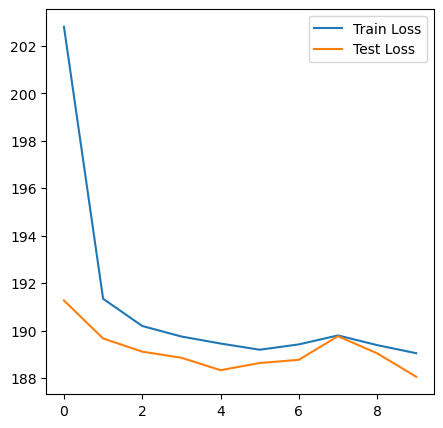

In [22]:
# plot the loss
plt.figure(figsize=(5, 5))
plt.plot(loss_train, label="Train Loss")
plt.plot(loss_test, label="Test Loss")
plt.legend()
plt.show()

## Evaluation

Text(0, 0.5, 'Predicted')

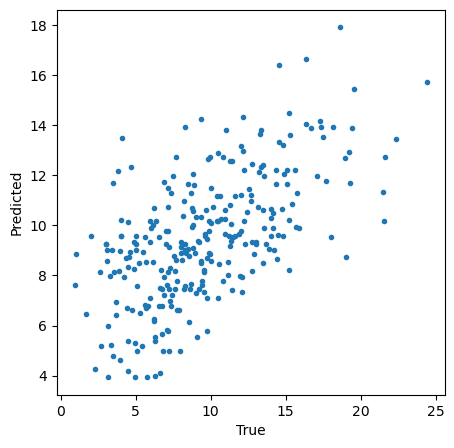

In [23]:
model.eval()

test_data = data_test[0]
test_pred = model(
    test_data.x.to(device),
    test_data.edge_index.to(device),
).detach().cpu().numpy().reshape(-1)

ref_val = test_data.y.detach().cpu().numpy().reshape(-1)

plt.figure(figsize=(5, 5))
plt.plot(ref_val, test_pred, ".")
plt.xlabel("True")
plt.ylabel("Predicted")

In [24]:
# save the model
torch.save(model.state_dict(), "model.pt")

continue training

0/120	train loss: 189.2238	test loss: 188.8809
1/120	train loss: 188.9215	test loss: 187.8070
2/120	train loss: 188.6924	test loss: 187.9101
3/120	train loss: 188.6847	test loss: 187.7598
4/120	train loss: 188.6063	test loss: 188.0632
5/120	train loss: 188.8640	test loss: 187.8839
6/120	train loss: 188.9440	test loss: 188.0646
7/120	train loss: 188.8644	test loss: 188.1565
8/120	train loss: 188.7444	test loss: 188.1004
9/120	train loss: 188.9491	test loss: 188.1654
10/120	train loss: 188.6299	test loss: 187.8193
11/120	train loss: 188.4351	test loss: 187.3254
12/120	train loss: 188.0112	test loss: 186.7926
13/120	train loss: 187.7913	test loss: 187.8903
14/120	train loss: 187.5448	test loss: 186.7753
15/120	train loss: 187.2913	test loss: 186.5484
16/120	train loss: 187.3957	test loss: 186.8025
17/120	train loss: 187.4823	test loss: 186.6485
18/120	train loss: 187.4796	test loss: 186.7709
19/120	train loss: 187.3505	test loss: 186.4324
20/120	train loss: 187.6044	test loss: 187.9997
21

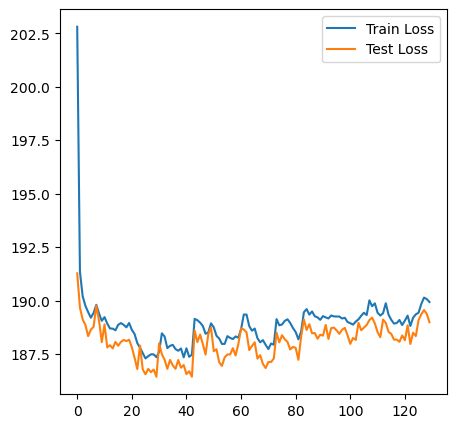

In [25]:
N_epochs = 120

for epoch in range(N_epochs):
    # training
    model.train()
    loss_train_epoch = 0
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        output = model(batch.x, batch.edge_index)
        loss = loss_fn(output, batch.y)
        loss.backward()
        optimizer.step()
        loss_train_epoch += loss.item() * batch.num_graphs
    loss_train.append(loss_train_epoch / len(train_loader))
    # testing
    model.eval()
    loss_test_epoch = 0
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            output = model(batch.x, batch.edge_index)
            loss = loss_fn(output, batch.y)
            loss_test_epoch += loss.item() * batch.num_graphs
        loss_test.append(loss_test_epoch / len(test_loader))

    print(f"{epoch}/{N_epochs}\ttrain loss: {loss_train[-1]:.4f}\ttest loss: {loss_test[-1]:.4f}")

    # save the model every 10 epochs
    if epoch % 10 == 0:
        torch.save(model.state_dict(), "model_cached.pt")

# plot the loss
plt.figure(figsize=(5, 5))
plt.plot(loss_train, label="Train Loss")
plt.plot(loss_test, label="Test Loss")
plt.legend()

# save the post train model
torch.save(model.state_dict(), "model.pt")

check again

Text(0, 0.5, 'Predicted')

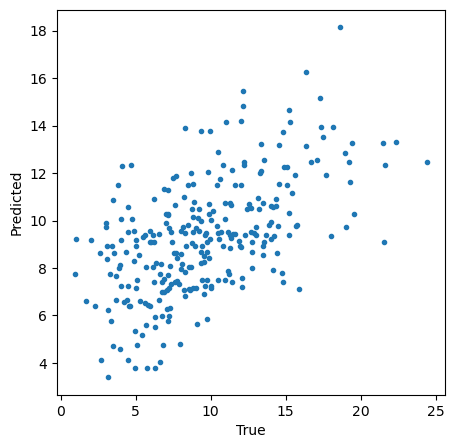

In [26]:
model.eval()

test_data = data_test[0]
test_pred = model(
    test_data.x.to(device),
    test_data.edge_index.to(device),
).detach().cpu().numpy().reshape(-1)

ref_val = test_data.y.detach().cpu().numpy().reshape(-1)

plt.figure(figsize=(5, 5))
plt.plot(ref_val, test_pred, ".")
plt.xlabel("True")
plt.ylabel("Predicted")